### Feature Selection und Modelling

In [2]:
import sys
sys.path = ["", ".."] + sys.path[1:]

In [3]:
import pathlib
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

import numpy as np
import aisfeel

/home/hdreesmann/.cache/pypoetry/virtualenvs/aisfeel-SSR1RHrp-py3.8/lib/python3.8/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


#### Input für dieses Notebook ist der Bereinigte Datensatz mit Cargo und Tanker Schiffen
Der Pfad muss in der nächsten Zeile angegeben werden.

In [10]:
data = pathlib.Path("/space/user/hdreesmann/")
aisdk_home = data / "aisdk"
cargo_tanker_features = aisdk_home / "cargo_tanker_weather_dataset"

In [56]:
cluster = LocalCluster(n_workers=24, 
                       threads_per_worker=2,
                       memory_limit='16GB')
cluster

LocalCluster(e9a04d66, 'tcp://127.0.0.1:33187', workers=24, threads=48, memory=384.00 GB)

In [57]:
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:33187' processes=24 threads=48, memory=384.00 GB>

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Task was destroyed but it is pending!
task: <Task pending name='Task-515568' coro=<DaskDistributedBackend._collect() running at /home/hdreesmann/.cache/pypoetry/virtualenvs/aisfeel-SSR1RHrp-py3.8/lib/python3.8/site-packages/joblib/_dask.py:198> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f8eae89a550>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /home/hdreesmann/.cache/pypoetry/virtualenvs/aisfeel-SSR1RHrp-py3.8/lib/python3.8/site-packages/tornado/ioloop.py:688]>


In [55]:
# cluster.close()

In [8]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS, ExhaustiveFeatureSelector as EFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [11]:
df = dd.read_parquet(cargo_tanker_features).drop(['type_of_mobile','eta',"latitude","longitude"],axis=1)

In [12]:
abebe = df.query("(sog >=5) & (`navigational_status_Under way using engine`==1)")

In [13]:
def weather_to_mag_and_dir(df):
    def magnitude(u, v):
        return (np.pi/180)*np.sqrt((np.square(u)+np.square(v)))
        
    def direction(u, v):
        return 180 + (180/np.pi*np.arctan2(u,v))
        
    current_u, current_v = df['eastward_sea_water_velocity_unit_m_s-1'], df['northward_sea_water_velocity_unit_m_s-1']
    wind_u, wind_v=  df['eastward_wind_unit_m_s-1'], df['northward_wind_unit_m_s-1']
    df["wind_magnitude"] = magnitude(wind_u,wind_v)
    df["wind_direction"] = direction(wind_u,wind_v)
    df["current_magnitude"] = magnitude(current_u, current_v)
    df["current_direction"] = direction(current_u,current_v)
    return df

def total_wave_period(df):
    df["total_wave_period"] = df["sea_surface_primary_swell_wave_mean_period_unit_s"] + df["sea_surface_primary_swell_wave_mean_period_unit_s"] + df["sea_surface_wind_wave_mean_period_unit_s"]
    return df

In [14]:
abebe = abebe.pipe(weather_to_mag_and_dir).pipe(total_wave_period)

In [ ]:
# abebe.columns

In [ ]:
# len(df) - len(abebe)

In [15]:
mmsi_counts = df.mmsi.value_counts().compute()

In [16]:
top = mmsi_counts.head(10).reset_index()["index"]
top

0    211141000
1    277560000
2    257653000
3    265411000
4    231794000
5    231613000
6    244645000
7    209525000
8    257723000
9    231670000
Name: index, dtype: int64

In [20]:
abebe = abebe[abebe.mmsi.isin(top)].compute()

saving the dataset

In [18]:
import joblib
joblib.dump(abebe, data / 'evaluation_dataset_D_1.joblib')

['/space/user/hdreesmann/abebe_evaluation_dataset.joblib']

In [19]:
len(abebe)

1416936

In [24]:
abebe

timestamp       mmsi  rot   sog    cog  heading  width  \
1441  2021-07-01 21:19:24  244645000  0.0   5.5   44.2     54.0   14.0   
1612  2021-01-26 08:32:59  244645000  0.0   5.9   87.1     86.0   14.0   
1612  2021-01-29 15:50:40  244645000  0.0   5.9   86.7     88.0   14.0   
1746  2021-01-24 06:58:06  244645000  0.0   6.0   26.7     33.0   14.0   
1906  2021-01-24 21:06:00  244645000  0.0   5.2  252.2    269.0   14.0   
...                   ...        ...  ...   ...    ...      ...    ...   
58262 2021-11-01 09:18:04  257723000  0.0  10.6   62.2     72.0   18.0   
59038 2021-11-01 09:18:32  257723000  0.0  10.4   69.4     74.0   18.0   
68237 2021-11-01 09:24:17  257723000  0.0  10.7  114.7    117.0   18.0   
86375 2021-11-01 09:35:43  257723000  0.0   8.3  124.3    114.0   18.0   
4614  2021-11-01 09:39:16  257723000  0.0   6.9   64.9     66.0   18.0   

       length  draught     a  ...            h3_res_4            h3_res_6  \
1441     68.0      3.5  58.0  ...  595023059790856191  604030251260968959   
1612     68.0      3.5  58.0  ...  595023059790856191  604030250589880319   
1612     68.0      3.5  58.0  ...  595023059790856191  604030250589880319   
1746     68.0      3.5  58.0  ...  595023059790856191  604030251260968959   
1906     68.0      3.5  58.0  ...  595023059790856191  604030250589880319   
...       ...      ...   ...  ...                 ...                 ...   
58262    80.0      5.3  20.0  ...  595024185072287743  604031376408182783   
59038    80.0      5.3  20.0  ...  595024185072287743  604031376408182783   
68237    80.0      5.3  20.0  ...  595024185072287743  604031376408182783   
86375    80.0      5.3  20.0  ...  595024185072287743  604031376542400511   
4614     80.0      5.3  20.0  ...  595024185072287743  604031376542400511   

                 h3_res_7            h3_res_8            h3_res_9  \
1441   608533850821230591  613037450442309631  617541050068631551   
1612   608533850150141951  613037449775415295  617541049401212927   
1612   608533850133364735  613037449754443775  617541049380241407   
1746   608533850821230591  613037450438115327  617541050064175103   
1906   608533850334691327  613037449959964671  617541049586548735   
...                   ...                 ...                 ...   
58262  608534976001998847  613038575618883583  617542175244943359   
59038  608534976001998847  613038575618883583  617542175244943359   
68237  608534975934889983  613038575555969023  617542175181504511   
86375  608534976152993791  613038575771975679  617542175398821887   
4614   608534976085884927  613038575706963967  617542175333810175   

       wind_magnitude  wind_direction  current_magnitude  current_direction  \
1441         0.093803      265.842434           0.005534         169.014496   
1612         0.253464       27.254290           0.007082         159.575089   
1612         0.253464       27.254290           0.005147         145.882355   
1746         0.253464       27.254290           0.007549         158.213608   
1906         0.253464       27.254290           0.005030         178.543640   
...               ...             ...                ...                ...   
58262        0.072433      306.184980           0.001013         337.750977   
59038        0.072433      306.184980           0.001013         337.750977   
68237        0.072433      306.184980           0.001013         337.750977   
86375        0.072433      306.184980           0.001013         337.750977   
4614         0.072433      306.184980           0.001013         337.750977   

       total_wave_period  
1441            7.980000  
1612            7.370000  
1612            6.320000  
1746            8.320000  
1906            7.290000  
...                  ...  
58262           8.219999  
59038           8.219999  
68237           8.219999  
86375           8.219999  
4614            8.219999  

[1416936 rows x 79 columns]

In [25]:
# Missing: Gross tonnage, Pressure MSL, Sea surface salitnity
abebe_features = ["wind_magnitude","wind_direction","current_magnitude","current_direction","sea_water_potential_temperature_unit_degrees_c","cog","sea_surface_wave_significant_height_unit_m", "sea_surface_wave_from_direction_unit_degree","total_wave_period","sog","draught"]
abebe_data = abebe[abebe_features]

#X_0 is the dataset with features from abebe, X_1 includes all features to be run through selection algorithm
#X_0 = D_0 in der Arbeit
X_0, y = abebe_data.drop("sog",axis=1), abebe_data.sog 
X_1 = abebe.drop(["sog","timestamp","mmsi"], axis=1)


In [39]:
abebe_data.head().T

1441        1612  \
wind_magnitude                                    0.093803    0.253464   
wind_direction                                  265.842434   27.254290   
current_magnitude                                 0.005534    0.007082   
current_direction                               169.014496  159.575089   
sea_water_potential_temperature_unit_degrees_c    3.036806    3.274849   
cog                                              44.200000   87.100000   
sea_surface_wave_significant_height_unit_m        0.450000    0.270000   
sea_surface_wave_from_direction_unit_degree     245.459991  325.849976   
total_wave_period                                 7.980000    7.370000   
sog                                               5.500000    5.900000   
draught                                           3.500000    3.500000   

                                                      1612        1746  \
wind_magnitude                                    0.253464    0.253464   
wind_direction                                   27.254290   27.254290   
current_magnitude                                 0.005147    0.007549   
current_direction                               145.882355  158.213608   
sea_water_potential_temperature_unit_degrees_c    1.880276    3.802210   
cog                                              86.700000   26.700000   
sea_surface_wave_significant_height_unit_m        0.250000    0.560000   
sea_surface_wave_from_direction_unit_degree      34.600006  171.750000   
total_wave_period                                 6.320000    8.320000   
sog                                               5.900000    6.000000   
draught                                           3.500000    3.500000   

                                                      1906  
wind_magnitude                                    0.253464  
wind_direction                                   27.254290  
current_magnitude                                 0.005030  
current_direction                               178.543640  
sea_water_potential_temperature_unit_degrees_c    4.861324  
cog                                             252.200000  
sea_surface_wave_significant_height_unit_m        0.240000  
sea_surface_wave_from_direction_unit_degree     184.050003  
total_wave_period                                 7.290000  
sog                                               5.200000  
draught                                           3.500000

In [1]:
cluster.close()

In [28]:
abebe_dtr_hyperparameters = {"min_samples_split":2,"min_samples_leaf":1, "max_features":6,"max_depth":60}

DTR_NULL = DecisionTreeRegressor(**abebe_dtr_hyperparameters)
DTR_ONE = DecisionTreeRegressor(**abebe_dtr_hyperparameters)


In [70]:
#im package ist außerdem die function select_features enthalten die wie in der Arbeit beschrieben Modell und Object zurückgibt
sfs_null = SFS(DTR_NULL, 
          k_features=10, 
          forward=False,
          floating=True, 
#           scoring='neg_mean_squared_error',
          cv=5,
          n_jobs=54,
            fixed_features=(0,1,2,3,4,5,6,7,8)
         )

sfs_one = SFS(DTR_ONE, 
          k_features=10, 
          forward=False, 
          floating=True, 
#           scoring='neg_mean_squared_error',
          cv=5,
          n_jobs=54,
#           pre_dispatch='None'
         )

In [74]:
# with joblib.parallel_backend('dask'):
print(f"Beginning training")
start = time.time()
sfs_null.fit(X_0, y)
print(f"training took {time.time()-start} seconds")

Beginning training


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


training took 35.60162568092346 seconds


In [75]:
import joblib
import time

# with joblib.parallel_backend('dask'):
print(f"Beginning training")
start = time.time()
sfs_one.fit(X_1, y)
print(f"training took {time.time()-start} seconds")

Beginning training
training took 18887.0443007946 seconds


In [110]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

def show_results(sfs, ylim):
    scores = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
    scores.sort_values('avg_score', inplace=True, ascending=False)
    fig1 = plot_sfs(sfs.get_metric_dict(),
                kind='std_dev',
                figsize=(12, 8))

    plt.ylim(ylim)
    plt.xlim([9, 50])
    plt.title('Sequential Floating Backward Selection (mit Standard Abweichungen)')
    plt.grid()
    plt.show()
    
    print('Best accuracy score: %.2f' % sfs.k_score_)
    print('Best subset (indices):', sfs.k_feature_idx_)
    print('Best subset (corresponding names):', sfs.k_feature_names_)
    
    return scores

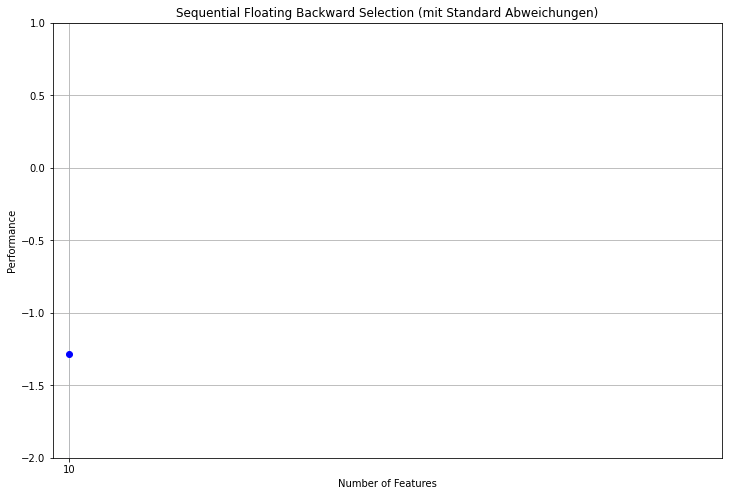

Best accuracy score: 0.00
Best subset (indices): (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
Best subset (corresponding names): ('wind_magnitude', 'wind_direction', 'current_magnitude', 'current_direction', 'sea_water_potential_temperature_unit_degrees_c', 'cog', 'sea_surface_wave_significant_height_unit_m', 'sea_surface_wave_from_direction_unit_degree', 'total_wave_period', 'draught')


avg_score  ci_bound                                          cv_scores  \
10 -1.284839  2.342865  [0.32891695837002344, -0.8943042055459169, -4....   

                       feature_idx  \
10  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)   

                                        feature_names   std_dev   std_err  
10  (wind_magnitude, wind_direction, current_magni...  1.822829  0.911414

In [111]:
scores = show_results(sfs_null, ylim=[-2, 1])
scores

Text(0, 0.5, 'Performance')

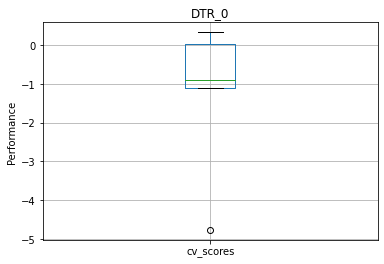

In [126]:
boxplot = scores.cv_scores.explode().to_frame().plot(kind="box")
boxplot.set_title("DTR_0")
boxplot.grid()
boxplot.set_ylabel("Performance")

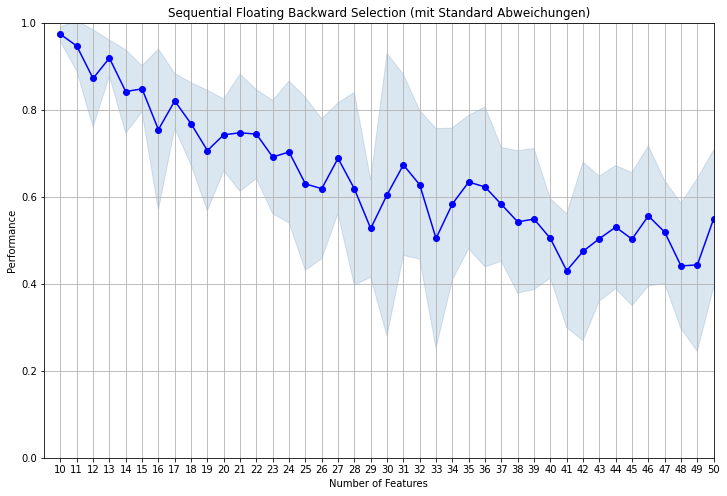

Best accuracy score: 0.97
Best subset (indices): (41, 42, 43, 48, 51, 53, 60, 61, 66, 67)
Best subset (corresponding names): ('ship_type_Tanker', 'cargo_type_No additional information', 'cargo_type_Category Y', 'navigational_status_Under way using engine', 'navigational_status_Under way sailing', 'navigational_status_Reserved for future amendment [WIG]', 'vx', 'vy', 'h3_res_4', 'h3_res_6')


feature_idx  \
10           (41, 42, 43, 48, 51, 53, 60, 61, 66, 67)   
11       (20, 41, 42, 43, 48, 51, 53, 60, 61, 66, 67)   
13  (8, 20, 41, 42, 43, 48, 53, 60, 61, 62, 64, 66...   
12    (8, 20, 41, 42, 43, 48, 53, 60, 61, 64, 66, 67)   
15  (8, 16, 20, 35, 41, 42, 43, 48, 53, 60, 61, 62...   
..                                                ...   
59  (0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 17, 19, 20, 22...   
66  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 17, 18,...   
69  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15,...   
56  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 17, 20, 22,...   
76  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                            cv_scores avg_score  \
10  [0.9951508627813189, 0.9463148117999424, 0.977...  0.973917   
11  [0.9840827008534668, 0.8337094788114393, 0.967...  0.947051   
13  [0.9228811835793005, 0.8486057761253878, 0.978...  0.919248   
12  [0.8888910123321635, 0.6564834849910677, 0.977...  0.872347   
15  [0.7943635108474696, 0.7781382007065524, 0.898...  0.848398   
..                                                ...       ...   
59  [0.5035282965758605, 0.27953677191471515, 0.56...  0.414949   
66  [0.5436530997131563, 0.4690633783460759, 0.311...  0.410571   
69  [0.5369027361396448, 0.23429184123221558, 0.51...  0.369777   
56  [0.5206166139126256, 0.30857609013570786, 0.63...  0.361198   
76  [0.46269173261056107, -0.48939226812259307, 0....  0.168707   

                                        feature_names  ci_bound   std_dev  \
10  (ship_type_Tanker, cargo_type_No additional in...  0.022271  0.017327   
11  (sea_surface_secondary_swell_wave_from_directi...  0.073557   0.05723   
13  (c, sea_surface_secondary_swell_wave_from_dire...  0.053191  0.041384   
12  (c, sea_surface_secondary_swell_wave_from_dire...  0.144051  0.112076   
15  (c, magnitude_of_surface_downward_stress_unit_...  0.068345  0.053175   
..                                                ...       ...       ...   
59  (rot, cog, heading, width, length, draught, a,...  0.186247  0.144906   
66  (rot, cog, heading, width, length, draught, a,...  0.108089  0.084097   
69  (rot, cog, heading, width, length, draught, a,...  0.172803  0.134447   
56  (rot, cog, heading, width, length, draught, a,...  0.256464  0.199538   
76  (rot, cog, heading, width, length, draught, a,...  0.518435   0.40336   

     std_err  
10  0.008664  
11  0.028615  
13  0.020692  
12  0.056038  
15  0.026587  
..       ...  
59  0.072453  
66  0.042048  
69  0.067223  
56  0.099769  
76   0.20168  

[67 rows x 7 columns]

In [100]:
scores_one = show_results(sfs_one, ylim=[0, 1])
scores_one

In [149]:
scores_one.iloc[0].to_frame().T.feature_names.explode().to_frame()

feature_names
10                                   ship_type_Tanker
10               cargo_type_No additional information
10                              cargo_type_Category Y
10         navigational_status_Under way using engine
10              navigational_status_Under way sailing
10  navigational_status_Reserved for future amendm...
10                                                 vx
10                                                 vy
10                                           h3_res_4
10                                           h3_res_6

In [137]:
scores_one.iloc[0].to_frame().T.cv_scores.explode().to_frame()

cv_scores
10  0.995151
10  0.946315
10  0.977568
10  0.986924
10  0.963626

Text(0, 0.5, 'Performance')

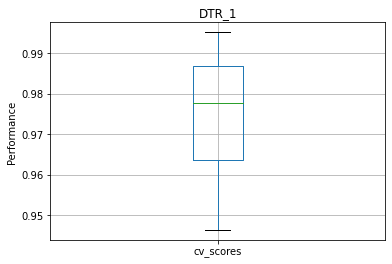

In [138]:
boxplot=scores_one.iloc[0].to_frame().T.cv_scores.explode().to_frame().plot(kind="box")
boxplot.set_title("DTR_1")
boxplot.grid()
boxplot.set_ylabel("Performance")

In [44]:
# selected_features = sfs.transform(X_1)

In [ ]:
# explainer = shap.Explainer(model)
# shap_values = explainer(selected_features)

In [79]:
joblib.dump(sfs_one, data/"sbfs_DTR_ONE.joblib")
joblib.dump(sfs_null, data/"sbfs_DTR_NULL.joblib")

['/space/user/hdreesmann/sbfs_DTR_NULL.joblib']